# KVLCC2 prediction woth Simplified ikedas method 

# Purpose
State the purpose of the notebook.

# Methodology
Quickly describe assumptions and processing steps.

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import rolldecayestimators

In [3]:
db = database.get_db()

In [4]:
sql = """
SELECT * from run
WHERE model_number='M5057-01-A' and test_type='roll decay' and project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine, index_col='id')

df_rolldecays['ship_speed'].fillna(0, inplace=True)


In [5]:
df_rolldecays[['date','ship_speed']]

,date,ship_speed
id,,
21337,2018-04-03,0.0
21338,2018-04-03,0.0
21339,2018-11-28,0.0
21340,2018-04-04,15.5


In [6]:
df_rolldecays=df_rolldecays.loc[[21337,21338]].copy()

In [7]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.999)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(2), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

In [8]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
#    ('offset_transformer',offset_transformer),
]


preprosessor = Pipeline(steps=steps)

In [9]:
def prepare_inputs(run):

    data = {}
    scale_factor=run.model.scale_factor
    rho=1000
    g=9.81
    data['rho']=rho
    data['g']=g
    
    data['lpp']=run.ship.lpp/scale_factor
    data['TA']=run.loading_condition.TA/scale_factor
    data['TF']=run.loading_condition.TF/scale_factor
    data['beam']=run.ship.beam/scale_factor
    
    if not run.ship.BKL:
        data['BKL']=0
    else:
        data['BKL']=run.ship.BKL/scale_factor
    
    if not run.ship.BKB:
        data['BKB']=0
    else:
        data['BKB']=run.ship.BKB/scale_factor
    
    
    data['kg']=run.loading_condition.kg/scale_factor
    data['Volume']=run.loading_condition.Volume/scale_factor**3
    data['gm']=run.loading_condition.gm/scale_factor
    
    if pd.isnull(run.ship_speed):
        data['V']=0
    else:
        data['V']=run.ship_speed*1.852/3.6/np.sqrt(scale_factor)  #[m/s]
    
    
    data['KXX']=run.loading_condition.KXX/scale_factor
    data['A0']=run.loading_condition.A0
    
    return data
    

In [29]:
models = OrderedDict()

for id,row in df_rolldecays.iterrows():
    run = db.session.query(Run).get(int(row.name))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    data = prepare_inputs(run=run)
    
    estimator_ikeda_quadratic = IkedaQuadraticEstimator(**data,
                                        verify_input=False, limit_inputs=False)
    
    preprosessor.fit(X=run.df[['phi']])
    X = preprosessor.transform(run.df[['phi']])

    estimator_ikeda_quadratic.fit(X=X)
    models[id] = estimator_ikeda_quadratic
    

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


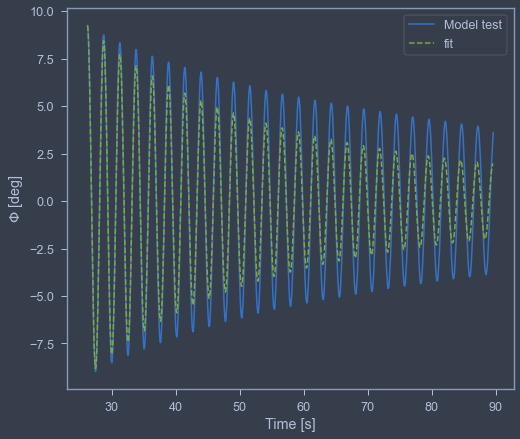

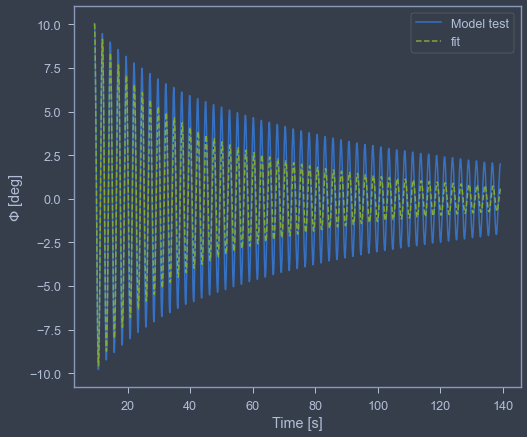

In [30]:
for id,model in models.items():
    model.plot_fit()

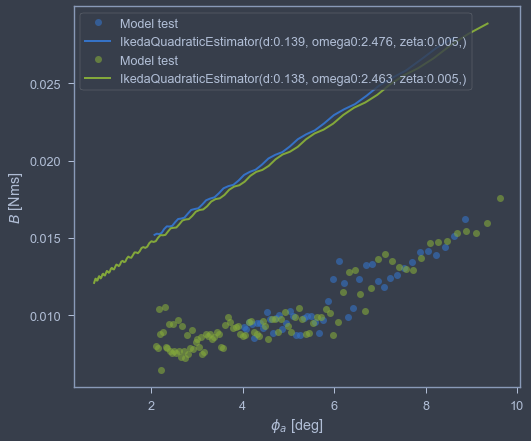

In [31]:
fig,ax=plt.subplots()

for id,model in models.items():
    
    model.plot_damping(ax=ax)

In [32]:
df_models = pd.DataFrame()

for id,model in models.items():
    
    s = pd.Series(data=model.result_for_database(),name=id)
    s['score']=model.score()
    df_models = df_models.append(s)
    

In [33]:
df_models

,B_1,B_2,B_44_1,B_44_2,B_BK_1,B_BK_2,B_E_1,B_E_2,B_F_1,B_F_2,B_L_1,B_L_2,B_W_1,B_W_2,B_e,d,omega0,omega0_fft,phi_start,phi_stop,score,zeta
21337,3.623144,18.662776,6.783642,9.944139,0.0,0.0,3.160498,6.320995,1.025137,1.025137,0.0,0.0,2.598007,2.598007,9.944139,0.139148,2.475575,2.475575,0.161181,0.063006,0.916215,0.005456
21338,3.562922,18.662776,6.983176,10.403430,0.0,0.0,3.420254,6.840508,1.022532,1.022532,0.0,0.0,2.540390,2.540390,10.403430,0.137739,2.463009,2.463009,0.175318,0.034732,0.828774,0.005338


<AxesSubplot:>

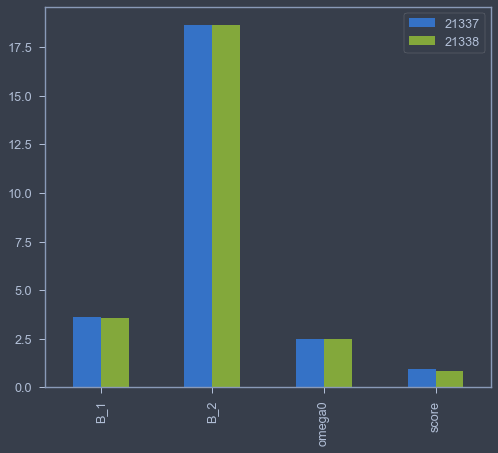

In [34]:
interesting = ['B_1','B_2','omega0','score']
df_models[interesting].transpose().plot(kind='bar')

In [35]:
phi_a = np.deg2rad(10)

B_e = lambdas.B_e_lambda(B_1=df_models['B_1'],
                         B_2=df_models['B_2'],
                         omega0=df_models['omega0'],
                         phi_a = phi_a)

In [36]:
g=9.81
rho=1000
scale_factor=run.model.scale_factor
Volume = run.loading_condition.Volume/(scale_factor**3)
beam = run.ship.beam/scale_factor
lambdas.B_hat_lambda(B=B_e, Disp=Volume, beam=beam,g=g, rho=rho)

21337    0.003017
21338    0.002990
dtype: float64